## Module 3 - In this jupyter notebook, perfomance indicators are calculated 
* Step 3a - Set up: Import modules/libraries, inport data, create output folder
* Step 3b - Calculate uniformity
* Step 3c - Calculate efficiency (beneficial fraction)
* Step 3d - Calculate adquacy
* Step 3e - Calculate relative water deficit 
**=====================================================================================================================**

![title](img/Fig3_1.png)

**=====================================================================================================================**
#### <span style='background :lightgreen' > References:
* Karimi, P., Bongani, B., Blatchford, M., and de Fraiture, C.: Global satellite-based ET products for the local level irrigation management: An application of irrigation performance assessment in the sugarbelt of Swaziland, Remote Sensing, 11, 705, 2019.
* Bastiaanssen, W. G., and Bos, M.: Irrigation performance indicators based on remotely sensed data: a review of literature, Irrigation and drainage systems, 13, 291-311, 1999.
* Bastiaanssen, W. G., Van der Wal, T., and Visser, T.: Diagnosis of regional evaporation by remote sensing to support irrigation performance assessment, Irrigation and Drainage Systems, 10, 1-23, 1996.

## Step 3a - Set up

## i) Import packages/libraries

In [1]:
import os
import sys
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# change the directory to where the modules are saved
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "Modules"))
from GIS_functions import GIS_function as gis

## ii) Import the input data
* Seasonal T, AETI, ETp 

In [2]:
# get seasonal data
T_fhs    = glob.glob(r'..\Data\2L2_T_season\*.tif')
AETI_fhs = glob.glob(r'..\Data\2L2_AETI_season\*.tif')
ETp_fhs  = glob.glob(r'..\Data\2L1_ETc_season\*.tif')

## iii) Output folder: Make one or connect to the existing one

In [3]:
# output_folder
output_folderBF = r'..\Data\3_BeneficialFraction'  # create output folder
output_folderAd = r'..\Data\3_Adequacy'  # create output folder

# Make one if the folder does not exit
if not os.path.exists(output_folderBF):
    os.makedirs(output_folderBF)
if not os.path.exists(output_folderAd):
    os.makedirs(output_folderAd)

## Step 3b - Calculate uniformity of water consumption
* Equity is defined as the coefficients of variation (CV) of seasonal ETa in the area of interest.
* It measures the evenness of the water supply in an irrigation scheme. 
* Note: CV of 0 to 10% is good, 10 to 25% is fair and CV > 25% is poor uniformity (Bastiaanssen et al., 1996) 
<br/>

In [4]:
# Uniformity of water Consumption 
# get seasonal AETI
# AETI_fhs = glob.glob(r'..\Data\2L2_AETI_season\*.tif') 

for i in range(len(AETI_fhs)):
    AETI = gis.OpenAsArray(AETI_fhs[i], nan_values=True)
    
    AETIm   = np.nanmean(AETI)
    AETIsd  = np.nanstd(AETI)
    
    CV_AETI = (AETIsd / AETIm) * 100
    
    # Identify the date from the file name
    date  = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ') 
    
    if CV_AETI < 10:
        U = 'Good Uniformity'
    if (CV_AETI >= 10) and (CV_AETI < 25):
        U = 'Fair Uniformity'
    else: 
        U = 'Poor Uniformity'

    print ('CV of AETI in', date, '=', round(CV_AETI, 1), ',', U)

## Step 3c - Calculate efficiency (beneficial fraction)
* Beneficial fraction is the ratio of the water that is consumed as transpiration compared to overall field water consumption (ETa). 
* $Beneficial fraction = \frac{T_a}{ET_a}$
* It is a measure of the efficiency of on farm water and agronomic practices in use of water for crop growth.

In [5]:
date  = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ') 
date

In [6]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = AETI_fhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster
  
for Tfh, ETfh in zip(T_fhs, AETI_fhs):
    T    = gis.OpenAsArray(Tfh,  nan_values=True)
    AETI = gis.OpenAsArray(ETfh, nan_values=True)
    
    T_over_AETI = T/AETI
    
    # Identify the date from the file name
    date  = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ') 
    
    # update the file name, and save into output folder
    basename  = os.path.basename(ETfh).replace('AETI', 'BF')  
    output_fn = os.path.join(output_folderBF, basename)
    gis.CreateGeoTiff(output_fn, T_over_AETI, driver, NDV, xsize, ysize, GeoT, Projection) 
    
    # Plot the raster map
    seasonal = T_over_AETI
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='BF [-]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Beneficial fraction [-] ' + date)
#     plt.clim(0,1)
    plt.show ()

    year += 1

## Step 3d - Calculate adequacy (relative evapotranspiration)
$Adequacy= \frac{ET_a}{ET_p}$

In [7]:
## Calculate and save raster adequacy layer

# collecting Geoinfo such as projection, the x and y axis
in_fh = AETI_fhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for ETfh, ETpfh in zip(AETI_fhs, ETp_fhs):
    AETI = gis.OpenAsArray(ETfh,  nan_values=True)
    ETp  = gis.OpenAsArray(ETpfh, nan_values=True)
    
    ETa_by_ETp = AETI / ETp
    
    # Identify the date from the file name
    date  = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ') 
        
    # update the file name, and save into output folder
    basename  = os.path.basename(ETfh).replace('AETI', 'Adequacy')
    output_fn = os.path.join(output_folderAd, basename)
    gis.CreateGeoTiff(output_fn, ETa_by_ETp, driver, NDV, xsize, ysize, GeoT, Projection) 
  
    # Plot the raster map
    seasonal = ETa_by_ETp
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Adequacy [-]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    plt.title('Adequacy [-] ' + date)
    plt.show ()

    year += 1
    ;

Text(0.88, 0.9, 'Good performance')

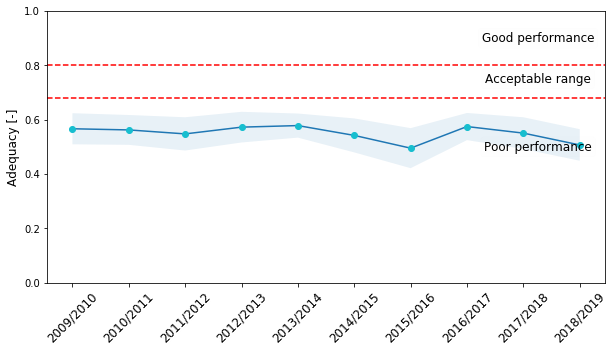

In [13]:
## Plot the adquacy
# read inputs
RelativeETfhs = glob.glob(r'..\Data\3_Adequacy\*.tif')  # get seasonal raster data

# initialize array
ET_by_ETpotMean = []
ET_by_ETpotStd  = []
season = []

year = 2009
for RelativeETfh in RelativeETfhs:
    ETbyETpot      = gis.OpenAsArray(RelativeETfh, nan_values=True)    
    ETbyETpot_mean = np.nanmean(ETbyETpot)
    ETbyETpot_std  = np.nanstd(ETbyETpot)

    ET_by_ETpotMean.append(ETbyETpot_mean)
    ET_by_ETpotStd.append(ETbyETpot_std)
    
    season.append(str(year) + '/' + str(year + 1))
    
    year += 1
    
# plot
x = season                     
y = ET_by_ETpotMean

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, '-')
plt.xticks(x, x, rotation='45', fontsize=12)

ax.plot(x, y, 'o', color='tab:cyan')
ax.set_ylim(0, 1)
ax.set_ylabel('Adequacy [-]', fontsize=12)

# shade the low and high range of the adequacy mean±SD
yl = np.array(y) - np.array(ET_by_ETpotStd)  # converting list to array
yh = np.array(y) + np.array(ET_by_ETpotStd)
ax.fill_between(x, yl, yh, alpha=0.1)

#Plot the thresholds
plt.axhline(y=0.68, color='r', linestyle='--') 
plt.axhline(y=0.8,  color='r', linestyle='--')

plt.text(0.88, 0.5, 'Poor performance',
         horizontalalignment='center', verticalalignment='center',
         transform=ax.transAxes,fontsize=12,
         bbox=dict(boxstyle="round",facecolor='green', alpha=0.005))

plt.text(0.88, 0.75, 'Acceptable range',
         horizontalalignment='center', verticalalignment='center',
         transform=ax.transAxes,fontsize=12,
         bbox=dict(boxstyle="round",facecolor='green', alpha=0.005))

plt.text(0.88, 0.9, 'Good performance',
         horizontalalignment='center', verticalalignment='center',
         transform=ax.transAxes,fontsize=12,
         bbox=dict(boxstyle="round",facecolor='green', alpha=0.005))

## Step 3e - Calculate Relative water Deficit (RWD)
$RWD= 1-\frac{ET_a}{ET_x}$
<br/>${ET_x} = $ Can be ETp or 99 percentile of the actual evapotranspiration

In [8]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = AETI_fhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster
   
for i in range(len(AETI_fhs)):
    AETI = gis.OpenAsArray(AETI_fhs[i], nan_values=True)
    
    # reshape the arrays
    AETI1_1D  = np.reshape(AETI,  AETI.shape[0]*AETI.shape[1])
    ETx       = np.nanpercentile(AETI1_1D, 99)
    
    AETI_mean = np.nanmean(AETI)
   
    RWD = 1-(AETI_mean/ETx)
    
    # Identify the date from the file name
    date  = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ') 
    
    print ('Relative water deficit', date, '=', round(RWD, 2))
        

    year += 1
    ;